# Setting

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=b7eb86165170bdeb32b36f027c3d1638b694f5cdb31847d5f05b1d0c14ba68b3
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
!pip install livelossplot

In [ ]:
!pip install pytorch_msssim torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.9 MB/s eta 0:00:00


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.0 MB/s eta 0:00:00



> Imports



In [ ]:
import os
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

from copy import deepcopy


> Connect to Google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# print(torch.cuda.get_device_name(0))

Using device: cuda


In [ ]:
# PyTorch Geometric format
# /content/drive/MyDrive/WildfirePaperCode/WildfirePaperData/Dataset
all_features_flat = np.load('JULES/GCN_LSTM_Paper/dataset/train_data_landed_v2.npy')
test_joint_data = np.load('JULES/GCN_LSTM_Paper/dataset/test_joint_data_landed_v2.npy')

In [ ]:
all_features_flat = all_features_flat
test_joint_data = test_joint_data
train_data = all_features_flat[:1080,:,:]
validation_data = all_features_flat[1080:,:,:]

In [ ]:
print(train_data.shape)
print(train_data.shape)
print(validation_data.shape)

(1080, 7771, 5)
(1080, 7771, 5)
(360, 7771, 5)


In [ ]:
num_timesteps = 12

from torch.utils.data import Dataset, DataLoader

class MultiStepForecastDataset(Dataset):
    def __init__(self, data, input_steps=12, output_steps=12):
        self.data = data
        self.input_steps = input_steps
        self.output_steps = output_steps

    def __len__(self):
        return self.data.shape[0] - (self.input_steps + self.output_steps) + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_steps, :, :]
        y = self.data[idx+self.input_steps:idx+self.input_steps+self.output_steps, :, 0:1]
        return x, y

# Create the custom dataset and dataloader
input_steps = num_timesteps
output_steps = num_timesteps
batch_size = 12

# Create the custom dataset and dataloader for each split
train_dataset = MultiStepForecastDataset(train_data, input_steps, output_steps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = MultiStepForecastDataset(validation_data, input_steps, output_steps)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for x_batch, y_batch in train_dataloader:
  print(x_batch.shape)
  print(y_batch.shape)
  break

torch.Size([12, 12, 7771, 5])
torch.Size([12, 12, 7771, 1])


In [ ]:
graph_data = torch.load('JULES/GCN_LSTM_Paper/dataset/ver_sparse_graph_data_v6.pt')
this_edge_index = graph_data['edge_index']
this_edge_weight = graph_data['edge_weight']
print(this_edge_index.shape)
print(this_edge_weight.shape)
print(this_edge_weight)

torch.Size([2, 2451043])
torch.Size([2451043])
tensor([0.6498, 0.8906, 0.8533,  ..., 0.7242, 0.6724, 0.5931])


In [ ]:
this_edge_index = this_edge_index.to(device)
this_edge_weight = this_edge_weight.to(device)

In [ ]:
class GCN_LSTM(nn.Module):
    def __init__(self, n_steps_in, n_steps_out, num_nodes, n_features):
        super(GCN_LSTM, self).__init__()

        self.gcn1 = GCNConv(n_features, 1)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.3)

        self.lstm1 = nn.LSTM(input_size=num_nodes, hidden_size=64, batch_first=True)
        self.relu1 = nn.ReLU()

        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.relu2 = nn.ReLU()

        self.dense1 = nn.Linear(64, 256)
        self.relu3 = nn.ReLU()

        self.dense2 = nn.Linear(256, num_nodes)
        self.relu4 = nn.ReLU()

        self.n_steps_out = n_steps_out
        self.num_nodes = num_nodes
        self.n_features = n_features

    def forward(self, x):
        gcn_outputs = []
        for t in range(x.shape[1]):
        # GCN layer, pass each time step's node feature matrix through GCN
            xi = x[:, t]
            xi = self.gcn1(xi, this_edge_index, this_edge_weight)
            xi = self.leaky_relu1(xi)
            gcn_outputs.append(xi)

        x = torch.stack(gcn_outputs, dim=1)

        x = x.view(-1, x.shape[1], self.num_nodes)  # Adjusting the flattening operation

        x, _ = self.lstm1(x)
        x = self.relu1(x)

        x, _ = self.lstm2(x)
        x = self.relu2(x)

        x = self.dense1(x)
        x = self.relu3(x)

        x = self.dense2(x)
        x = self.relu4(x)

        x = x.view(-1, self.n_steps_out, self.num_nodes, 1)  # Reshape to original dimensions

        return x


num_nodes = all_features_flat.shape[1]
num_features = all_features_flat.shape[2]
gcn_lstm_model = GCN_LSTM(num_timesteps, num_timesteps, num_nodes, num_features).to(device)
GCN_LSTM(12, 12, 112*192, 5)
gcn_lstm_model.load_state_dict(torch.load('JULES/GCN_LSTM_Paper/model_states/v21_best_model_weights.pth'))

<All keys matched successfully>

In [ ]:
next(iter(validation_dataloader))[0][0, :, :, :].shape

torch.Size([12, 7771, 5])

Variable Names:
longitude (192,)
latitude (144,)
field36 (144, 192)

Dimension Names and Sizes:
longitude 192
latitude 144
(112, 192)


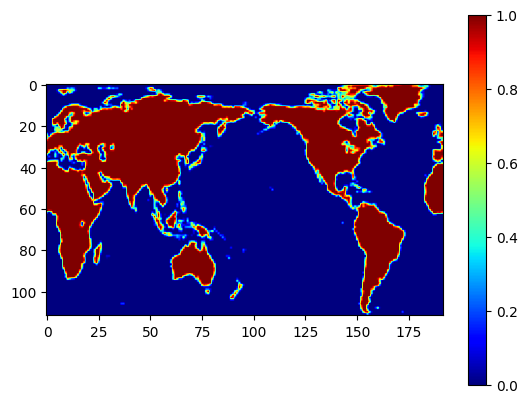

In [ ]:
import netCDF4 as nc
import numpy as np

# Open the netCDF file
nc_file = nc.Dataset('JULES/CRU-NCEPv7.landfrac.nc', mode='r')

print('Variable Names:')
for var_name in nc_file.variables:
    var = nc_file.variables[var_name]
    print(var_name, var.shape)

print('\nDimension Names and Sizes:')
for dim_name in nc_file.dimensions:
    dim = nc_file.dimensions[dim_name]
    print(dim_name, len(dim))

var = nc_file.variables['field36'][27:-5,:]

# Close the netCDF file
nc_file.close()

# Convert the variable to a NumPy array
land_mask = np.array(var)

print(land_mask.shape)


# Create a heatmap plot of the NumPy array
plt.imshow(land_mask[::-1], cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
class MyMinMaxScaler:
    def __init__(self, feature_range=(-1, 1)):
        self.min, self.max = feature_range

    def fit_transform(self, data):
        data_min = np.min(data)
        data_max = np.max(data)
        diff = data_max - data_min or 1
        data_scaled = self.min + (data - data_min) * (self.max - self.min) / diff
        return data_scaled

In [ ]:
import numpy as np

# Compressing data
def compress_data(data, land_mask):
    timesteps, height, width, _ = data.shape
    compressed_data = data.reshape(timesteps, -1)[:, land_mask.flatten() > 0]
    return compressed_data.reshape(timesteps, -1, 1)

# Decompress and mapping back to original shape
def decompress_data(compressed_data, land_mask):
    timesteps, _, _ = compressed_data.shape
    decompressed_data = np.zeros((timesteps, land_mask.size, 1))
    decompressed_data[:, land_mask.flatten()> 0, :] = compressed_data
    return decompressed_data.reshape(timesteps, land_mask.shape[0], land_mask.shape[1], 1)

In [ ]:
from captum.attr import IntegratedGradients
from tqdm import tqdm

model = gcn_lstm_model
ig = IntegratedGradients(model)

# Use the fisrt validation batch

N = 4
input_data = next(iter(validation_dataloader))[0][N:N+1]

input_data = input_data.to(device)

target_node = 3380
# 1555, 3380

y, x = np.where(land_mask)
compressed_index = target_node

x_coord = x[compressed_index]
y_coord = y[compressed_index]

T =  11  # choose one time; 11 for 3380; 5 for 1555

# calculate attribution values for this node with specific time
node_attributions = ig.attribute(input_data, target=(T, target_node), n_steps=50)

node_attributions = node_attributions.cpu()
node_attributions = torch.sum(node_attributions, dim=0, keepdim=True)
node_attributions.shape

torch.Size([1, 12, 7771, 5])

In [ ]:
node_attributions_feature = node_attributions[:,:,:,0]
'''
['Burnt area', 'Temperature', 'Rainfall', 'Humidity', 'Lightning']
'''
node_attributions_feature = np.reshape(node_attributions_feature, (12, 7771, 1))

In [ ]:
community_grid = np.load("JULES/GCN_LSTM_Paper/dataset/community_grid.npy")
target_community = 5 # cluster 5 for 3380; cluster 4 for 1555
community_mask = np.where(community_grid == target_community, 1, 0)

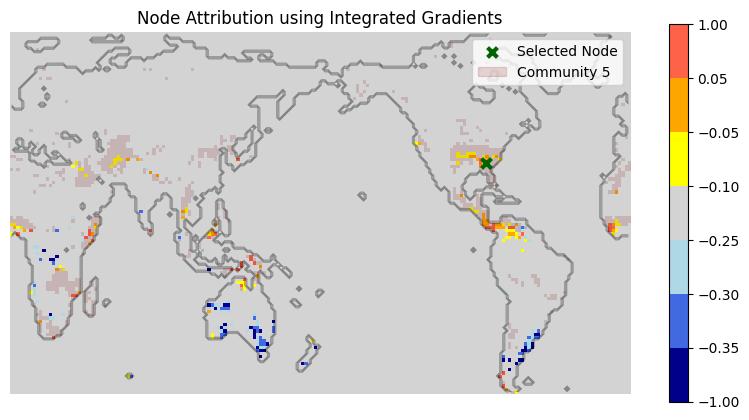

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

land_mask[land_mask != 0] = 1

decompressed_total_attr_value = decompress_data(node_attributions_feature, land_mask)
decompressed_total_attr_value.shape

# summed_attr_value = decompressed_total_attr_value[1]
summed_attr_value = np.sum(decompressed_total_attr_value, axis=0)


scaler = MyMinMaxScaler()
sum_array = scaler.fit_transform(summed_attr_value)


colors = [
    '#00008B',
    '#4169E1',
    '#ADD8E6',
    'lightgrey',
    'yellow',
    '#FFA500',
    '#FF6347',
]

boundaries = [-1, -0.35, -0.3, -0.25, -0.1, -0.05, 0.05, 1.0]
# boundaries = [-1, -0.45, -0.3, -0.2, 0.1, 0.2, 0.25, 1.0]
norm = mcolors.BoundaryNorm(boundaries, len(colors))


fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(sum_array[::-1], cmap=mcolors.ListedColormap(colors), norm=norm)
ax.contour(land_mask[::-1], colors='k', linewidths=0.1)

ax.set_title('Node Attribution using Integrated Gradients')

rgba_mask = np.zeros((community_mask.shape[0], community_mask.shape[1], 4))
rgba_mask[community_mask == 1] = [0.5, 0.0, 0, 0.15]  # [R, G, B, A]

ax.imshow(rgba_mask[::-1])


red_scatter = ax.scatter(x_coord, summed_attr_value.shape[0] - y_coord - 1, color='darkgreen', s=50, marker='x', label='Selected Node', linewidth=3)
community_patch = mpatches.Patch(color=[0.5, 0, 0, 0.15], label= f"Community {target_community}")

ax.legend(handles=[red_scatter, community_patch])

cbar = plt.colorbar(im, ax=ax, shrink=0.7, boundaries=boundaries, ticks=boundaries)

plt.axis('off')
plt.show()


In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from tqdm import tqdm

model = gcn_lstm_model

# Initialise Integrated Gradients
ig = IntegratedGradients(model)

N = 1

# Use the fisrt validation batch

input_data = next(iter(validation_dataloader))[0][:N]

input_data = input_data.to(device)

total_attributions = []

T = 10

nodes = 500

for node in tqdm(range(nodes), desc=f"Processing nodes"):
    # calculate node attribution
    node_attributions = ig.attribute(input_data, target=(T, node), n_steps=50)
    total_attributions.append(torch.sum(node_attributions, dim=(0, 1, 2)))

Processing nodes: 100%|██████████| 500/500 [04:39<00:00,  1.79it/s]


In [ ]:
stacked_tensor = torch.stack(total_attributions, dim=0)

In [ ]:
stacked_tensor.shape

torch.Size([500, 5])

In [ ]:
min_values, _ = torch.min(stacked_tensor, dim=0, keepdim=True)
max_values, _ = torch.max(stacked_tensor, dim=0, keepdim=True)
scaled_tensor = 2 * ((stacked_tensor - min_values) / (max_values - min_values)) - 1

# print(scaled_tensor)

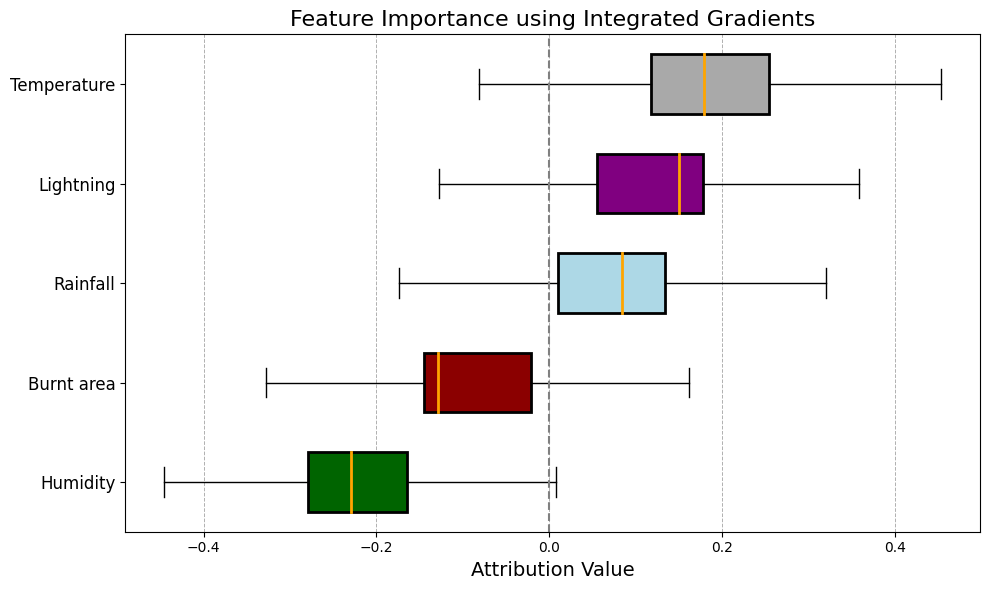

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

data = scaled_tensor.cpu().numpy()

# sort with median
medians = np.median(data, axis=0)
sort_idx = np.argsort(medians)

sorted_data = data[:, sort_idx]
full_names = np.array(['Burnt area', 'Temperature', 'Rainfall', 'Humidity', 'Lightning'])[sort_idx]

colors = ['darkred', 'darkgrey', 'lightblue', 'darkgreen', 'purple']
sorted_colors = np.array(colors)[sort_idx]

plt.figure(figsize=(10, 6))
bplots = plt.boxplot(sorted_data, vert=False, patch_artist=True, widths=0.6, showfliers=False)

# colour and line config
for patch, color, median_line in zip(bplots['boxes'], sorted_colors, bplots['medians']):
    patch.set_facecolor(color)
    patch.set_linewidth(2)
    median_line.set_linewidth(2)
    median_line.set_color('orange')  # configuring median line

# add line at 0
plt.axvline(0, color='grey', linestyle='--', linewidth=1.5)

# set title and labels
plt.title("Feature Importance using Integrated Gradients", fontsize=16)
plt.xlabel("Attribution Value", fontsize=14)
plt.yticks(range(1, len(full_names) + 1), [f"{full_name}" for full_name in full_names], fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.7)

# show
plt.tight_layout()
plt.show()
